In [1]:
import os
from deep_dating.datasets import DatasetName, DatingDataLoader, SetType, CrossVal, CLaMM, MPS
from deep_dating.networks import DatingCNN, DatingTrainer, Autoencoder
from deep_dating.util import DATASETS_PATH
from deep_dating.prediction import DatingPredictor
from preprocessing import preprocess_autoencoder, preprocess_dating_cnn
from sklearn.manifold import TSNE
from deep_dating.metrics import DatingMetrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os 
import shutil
from deep_dating.util import DATASETS_PATH
import cv2
import pickle
from deep_dating.preprocessing import PreprocessRunner
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np

Seed set to 42


In [30]:
run_path =  "runs/auto_mps/" #"runs/Jan8-19-25-16/" #"runs/Jan6-22-21-16/" #"runs/Dec21-16-31-47"
model_name = "model_epoch_24"
all_labels_, all_outputs_, all_paths_ = DatingPredictor().load(os.path.join(run_path, model_name + "_feats_train_mps.pkl"))
all_labels_val_, all_outputs_val_, all_paths_val_ = DatingPredictor().load(os.path.join(run_path, model_name + "_feats_val_mps.pkl"))

In [32]:
all_labels = all_labels_.flatten()
print(all_labels)
all_labels_val = all_labels_val_.flatten()
print(all_labels_val)

[1525. 1375. 1300. ... 1450. 1500. 1525.]
[1400. 1525. 1375. ... 1550. 1500. 1450.]


In [24]:
labels = np.unique(all_labels_)
labels

array([1000., 1050., 1150., 1225., 1275., 1325., 1375., 1413., 1438.,
       1463., 1488., 1513., 1538., 1563., 1588.], dtype=float32)

In [25]:
all_outputs_.shape

tsne = TSNE(n_components=2)
tsne = PCA(n_components=2)
features_tsne_2d = tsne.fit_transform(all_outputs_)

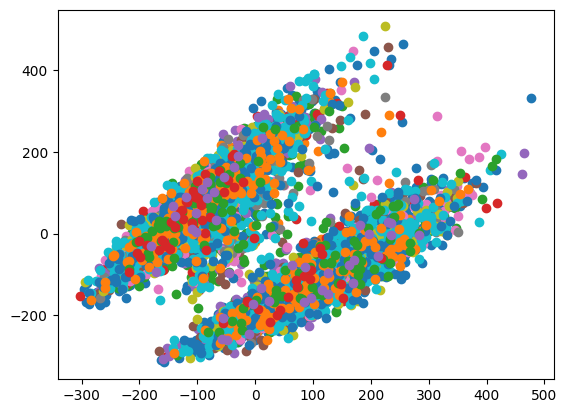

In [26]:
for l in labels:
    idxs = np.where(all_labels_ == l)[0]
    plt.scatter(features_tsne_2d[idxs, 0], features_tsne_2d[idxs, 1])
plt.show()

In [40]:
def get_feat(labels, outputs, paths):
    preds = {}

    for i, img_name in enumerate(paths):
        img_name = PreprocessRunner.get_base_img_name(img_name)
        if not img_name in preds:
            preds[img_name] = [labels[i], [outputs[i]]]
        else:
            preds[img_name][1].append(outputs[i])

    features = []
    labels_new = []
    print(preds.keys())
    for key, val in preds.items():
        preds[key][1] = np.mean(preds[key][1], axis=0)
        
        features.append(preds[key][1])
        labels_new.append(preds[key][0])

    features = np.array(features)
    return features, np.array(labels_new), preds

train_feat, train_labels, train_feat_preds = get_feat(all_labels, all_outputs_, all_paths_)
val_feat, val_labels, val_feat_preds = get_feat(all_labels_val, all_outputs_val_, all_paths_val_)

dict_keys(['MPS1525_0030__1505_1525', 'MPS1375_0265__908_1375', 'MPS1300_0028__544_1300', 'MPS1400_0306__193_1400', 'MPS1475_0131__1170_1475', 'MPS1450_0247__146_1450', 'MPS1450_0494__275_1450', 'MPS1375_0209__51_1375', 'MPS1425_0152__111_1425', 'MPS1425_0012__895_1425', 'MPS1525_0046__722_1525', 'MPS1450_0535__205_1450', 'MPS1425_0153__2_1425', 'MPS1500_0209__1206_1500', 'MPS1350_0193__12_1350', 'MPS1350_0189__262_1350', 'MPS1500_0085__672_1500', 'MPS1475_0419__509_1475', 'MPS1325_0056__1692_1325', 'MPS1500_0313__75_1500', 'MPS1525_0096__373_1525', 'MPS1375_0280__1724_1375', 'MPS1375_0347__1156_1375', 'MPS1450_0165__676_1450', 'MPS1425_0212__678_1425', 'MPS1375_0220__1153_1375', 'MPS1500_0388__165_1500', 'MPS1450_0551__545_1450', 'MPS1475_0018__276_1475', 'MPS1450_0161__1200_1450', 'MPS1300_0011__1255_1300', 'MPS1475_0482__621_1475', 'MPS1350_0115__1672_1350', 'MPS1500_0378__277_1500', 'MPS1500_0197__571_1500', 'MPS1525_0066__690_1525', 'MPS1525_0105__44_1525', 'MPS1525_0027__222_1525

In [8]:
svm = SVC()
svm.fit(train_feat, train_labels)

SVC()

In [9]:
val_predict_labels = svm.predict(val_feat)

alphas = [0, 25, 50, 75, 100]
metrics = DatingMetrics(alphas=alphas)
metrics.names

vals = metrics.calc(val_labels, val_predict_labels)

mae, mse = tuple(vals[:2])
cs_ = vals[2:]
# print(cs_)

# plt.plot(alphas, cs_)
# plt.xlabel("Alpha Value")
# plt.ylabel("Cumulative Score")
# plt.ylim(0, 100)
# plt.xticks(np.arange(0, 55, 5))
# plt.axvline(x=25, color="red")
# plt.show()

print(mae, mse)
print(alphas)
print(cs_)

# 47.45140388768898 4557.235421166307
# [0, 25, 50, 75, 100]
# [31.01511879049676, 51.360691144708426, 67.34341252699784, 80.47516198704103, 89.8488120950324]

48.198689956331876 4624.727074235808
[0, 25, 50, 75, 100]
[27.292576419213976, 51.96506550218341, 70.52401746724891, 79.6943231441048, 87.77292576419214]


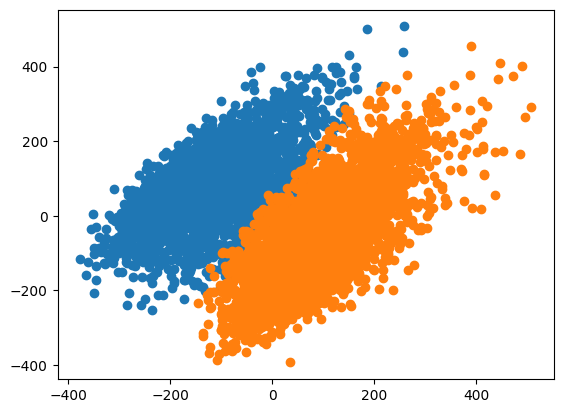

In [10]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(all_outputs_)
kmeans.labels_
# os.mkdir("group_0")
# os.mkdir("group_1")

paths = np.array(all_paths_)

for i in range(2):
    idxs = np.where(kmeans.labels_ == i)[0]

    # for path in paths[idxs]:
    #     img_name = os.path.basename(path)
    #     path = os.path.join(DATASETS_PATH, "CLAMM_Set_Auto_Bin", img_name)
    #     shutil.copy(path, os.path.join(f"group_{i}", img_name))

    plt.scatter(features_tsne_2d[idxs, 0], features_tsne_2d[idxs, 1])
plt.show()

In [11]:
import torch

model_path = "runs/auto_mps/model_epoch_24.pt" #"runs/Jan8-19-25-16/model_epoch_3.pt"

model = Autoencoder()
model.load(model_path, continue_training=True)

imgs = [os.path.join(DATASETS_PATH, "MPS_Set_Auto/MPS1500_0347__10_1500_p1.png")]

patches = [model.transform_img(x) for x in imgs]
patches = torch.from_numpy(np.array(patches))

output = model(patches)
output = output.cpu().detach().numpy()

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "l1.weight", "l1.bias", "l2.weight", "l2.bias". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.1.weight", "encoder.1.bias", "encoder.1.running_mean", "encoder.1.running_var", "encoder.1.num_batches_tracked", "encoder.3.weight", "encoder.3.bias", "encoder.4.weight", "encoder.4.bias", "encoder.4.running_mean", "encoder.4.running_var", "encoder.4.num_batches_tracked", "encoder.6.weight", "encoder.6.bias", "encoder.7.weight", "encoder.7.bias", "encoder.7.running_mean", "encoder.7.running_var", "encoder.7.num_batches_tracked", "encoder.9.weight", "encoder.9.bias", "encoder.10.weight", "encoder.10.bias", "encoder.10.running_mean", "encoder.10.running_var", "encoder.10.num_batches_tracked", "encoder.12.weight", "encoder.12.bias", "encoder.13.weight", "encoder.13.bias", "encoder.13.running_mean", "encoder.13.running_var", "encoder.13.num_batches_tracked", "encoder.16.weight", "encoder.16.bias", "decoder.0.weight", "decoder.0.bias", "decoder.3.weight", "decoder.3.bias", "decoder.4.weight", "decoder.4.bias", "decoder.4.running_mean", "decoder.4.running_var", "decoder.4.num_batches_tracked", "decoder.6.weight", "decoder.6.bias", "decoder.7.weight", "decoder.7.bias", "decoder.7.running_mean", "decoder.7.running_var", "decoder.7.num_batches_tracked", "decoder.9.weight", "decoder.9.bias", "decoder.10.weight", "decoder.10.bias", "decoder.10.running_mean", "decoder.10.running_var", "decoder.10.num_batches_tracked", "decoder.12.weight", "decoder.12.bias", "decoder.14.weight", "decoder.14.bias", "decoder.14.running_mean", "decoder.14.running_var", "decoder.14.num_batches_tracked", "decoder.15.weight", "decoder.15.bias". 

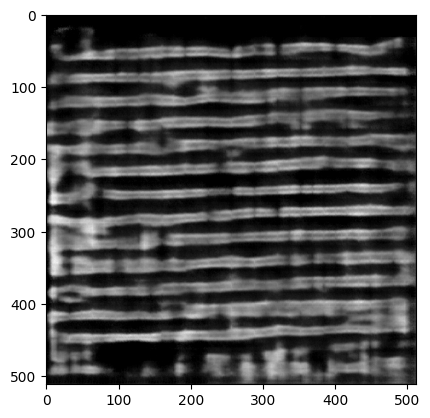

In [ ]:
plt.imshow(output[0, 0, :, :], cmap="gray")
plt.show()

In [12]:
def get_feat2(file_name="vgg19_feats_SetType.TRAIN"):
    with open(file_name, "rb") as f:
        all_labels, all_outputs, all_paths = pickle.load(f)

    #print(all_labels)
    # all_labels = np.concatenate(all_labels)
    # all_outputs = np.concatenate(all_outputs)
    

    preds = {}

    for i, img_name in enumerate(all_paths):
        img_name = PreprocessRunner.get_base_img_name(img_name)
        img_name = img_name.split("__")[0]
        if not img_name in preds:
            preds[img_name] = [all_labels[i], [all_outputs[i]]]
        else:
            preds[img_name][1].append(all_outputs[i])

    features = []
    labels = []
    for key, val in preds.items():
        preds[key][1] = np.mean(preds[key][1], axis=0)
        features.append(preds[key][1])
        labels.append(preds[key][0])
        # print(preds[key][1].shape)
        # exit()
    features = np.array(features)
    return features, np.array(labels), preds

train_x, train_y, train_preds = get_feat2("runs/Feb2-13-25-11/model_epoch_4_feats_train.pkl")
val_x, val_y, val_preds = get_feat2("runs/Feb2-13-25-11/model_epoch_4_feats_val.pkl")

In [13]:
print(train_x.shape, train_feat.shape, val_x.shape)

(1796, 1536) (1828, 512) (453, 1536)


In [27]:
def get_feat3(p, labels, outputs, paths):
    preds = {}

    l = [x.split("__")[0] for x in list(p.keys())]

    for i, img_name in enumerate(paths):
        img_name = PreprocessRunner.get_base_img_name(img_name)
        img_name = img_name.split("__")[0]
        if img_name.split("__")[0] not in l:
            continue
        if not img_name in preds:
            preds[img_name] = [labels[i], [outputs[i]]]
        else:
            preds[img_name][1].append(outputs[i])

    features = []
    labels_new = []
    print(preds.keys())
    print(p.keys())
    for key, val in p.items():
        preds[key][1] = np.mean(preds[key][1], axis=0)
        
        features.append(preds[key][1])
        labels_new.append(preds[key][0])

    features = np.array(features)
    return features, np.array(labels_new), preds

train_feat, train_labels, train_feat_preds = get_feat3(train_preds, all_labels, all_outputs_, all_paths_)
val_feat, val_labels, val_feat_preds = get_feat3(val_preds, all_labels_val, all_outputs_val_, all_paths_val_)

dict_keys([])
dict_keys(['MPS1450_0507', 'MPS1450_0246', 'MPS1475_0219', 'MPS1475_0416', 'MPS1375_0359', 'MPS1475_0055', 'MPS1500_0070', 'MPS1500_0421', 'MPS1525_0072', 'MPS1500_0400', 'MPS1450_0554', 'MPS1525_0083', 'MPS1450_0142', 'MPS1400_0017', 'MPS1500_0093', 'MPS1375_0174', 'MPS1500_0172', 'MPS1500_0002', 'MPS1550_0006', 'MPS1450_0497', 'MPS1500_0348', 'MPS1475_0146', 'MPS1525_0270', 'MPS1400_0069', 'MPS1500_0281', 'MPS1425_0253', 'MPS1475_0013', 'MPS1500_0327', 'MPS1300_0025', 'MPS1450_0245', 'MPS1550_0043', 'MPS1525_0219', 'MPS1500_0347', 'MPS1375_0068', 'MPS1425_0198', 'MPS1375_0126', 'MPS1500_0003', 'MPS1400_0161', 'MPS1350_0058', 'MPS1425_0190', 'MPS1475_0214', 'MPS1475_0138', 'MPS1525_0053', 'MPS1375_0070', 'MPS1500_0140', 'MPS1350_0062', 'MPS1500_0383', 'MPS1475_0443', 'MPS1475_0108', 'MPS1475_0476', 'MPS1475_0455', 'MPS1450_0518', 'MPS1525_0198', 'MPS1350_0124', 'MPS1450_0111', 'MPS1400_0063', 'MPS1525_0123', 'MPS1525_0242', 'MPS1400_0165', 'MPS1550_0107', 'MPS1375_0132',

KeyError: 'MPS1450_0507'

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

scaler = StandardScaler()

In [16]:
new_train_x = np.hstack([train_feat])
print(new_train_x.shape)
new_train_x_scaled = scaler.fit_transform(new_train_x)

new_val_x = np.hstack([val_feat])
new_val_x_scaled = scaler.transform(new_val_x)

(1796, 512)


In [43]:
c = DummyClassifier(strategy="uniform")
c.fit(train_feat, train_labels)
val_predict_labels = c.predict(val_feat)

alphas = [0, 25, 50, 75]
metrics = DatingMetrics(alphas=alphas)
metrics.names

vals = metrics.calc(val_labels, val_predict_labels)

mae, mse = tuple(vals[:2])
cs_ = vals[2:]

print(mae, mse)
print(alphas)
print(cs_)

# 7.50551876379691 350.4415011037528
# [0, 25, 50, 75, 100]
# [78.80794701986756, 94.48123620309052, 97.57174392935983, 99.11699779249447, 100.0]

# 47.737306843267106 4443.9845474613685
# [0, 25, 50, 75, 100]
# [26.71081677704194, 50.77262693156733, 70.6401766004415, 80.79470198675497, 89.1832229580574]

82.15065502183405 10367.085152838428
[0, 25, 50, 75]
[8.73362445414847, 28.38427947598253, 44.32314410480349, 59.60698689956332]
